<a href="https://colab.research.google.com/github/IKnigencev/Deep-Learning-example/blob/main/20writers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом блокноте используются тексты 20 русских писателей. В конце обучения можно использовать сеть для проверки стиля текста.

Данные были разделены на тренировочные и валидационные. Использовались рекурентные нейронные сети. 

[Ссылка на архив](https://drive.google.com/file/d/1mIMSF_1RuAKDC7CUZoc1eNxBHW0Fuh8V/view?usp=sharing)


## Необходимые бибилиотеки

In [ ]:
import numpy as np

import time

import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import utils

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation

from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import gc 

%matplotlib inline

## Загрузка данных

In [ ]:
# Ссылка на данные 
URL = 'https://drive.google.com/file/d/1mIMSF_1RuAKDC7CUZoc1eNxBHW0Fuh8V/view?usp=sharing'

In [ ]:
# Загрузка данных 
import gdown
gdown.download(URL, None, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip
To: /content/20writers.zip
100%|██████████| 28.5M/28.5M [00:01<00:00, 14.4MB/s]


'20writers.zip'

In [ ]:
# Разорхивирование данных 
!unzip '20writers'  -d train

Archive:  20writers.zip
  inflating: train/Грибоедов.txt  
  inflating: train/Достоевский.txt  
  inflating: train/Каверин.txt  
  inflating: train/Катаев.txt  
  inflating: train/Куприн.txt  
  inflating: train/Лермонтов.txt  
  inflating: train/Лесков.txt  
  inflating: train/Носов.txt    
  inflating: train/Пастернак.txt  
  inflating: train/Пушкин.txt  
  inflating: train/Толстой.txt  
  inflating: train/Тургенев.txt  
  inflating: train/Чехов.txt    
  inflating: train/Шолохов.txt  
  inflating: train/Беляев.txt  
  inflating: train/Булгаков.txt  
  inflating: train/Васильев.txt  
  inflating: train/Гоголь.txt  
  inflating: train/Гончаров.txt  
  inflating: train/Горький.txt  


## Глобальные переменные

In [ ]:
path_data = '/content/train'

VAL_SPLIT = 0.2

VOCAB_SIZE = 20000
WIN_SIZE = 2000
WIN_HOP = 250

EPOCHS = 15
BATCH_SIZE = 128

## Утилиты

### Загрузка и преобразование данных

In [ ]:
def load_data(path_data, VAL_SPLIT):
  # Загрузка данных 

  t = time.time()

  CLASS_LIST = []
  x_train = []
  x_val = []

  for data in os.listdir(path_data):
    with open(path_data + '/' + data, 'r') as f:
      text = f.read()
    text = text.replace('\n', ' ')
    test = int(len(text) * VAL_SPLIT)
    x_train.append(text[:(len(text)-test)])
    x_val.append(text[(len(text)-test):])

    CLASS_LIST.append(data[:-4])

  print(f'Время загрузки данных: {time.time() - t}')

  return x_train, x_val, CLASS_LIST

In [ ]:
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

def vectorize_sequence(seq_list, win_size, hop):
  # Функция формирования выборок из последовательностей индексов

    class_count = len(seq_list)
    x, y = [], []

    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    return np.array(x), np.array(y)

### Статистика текста

In [ ]:
def gate_len_element_array(data, class_name):
    # Получить количество элементов в каждой ячейке массива 

    lenght =[]

    for cl in range(len(data)):
      print(f'В классе {class_name[cl]}:  {len(data[cl])} слов')
      lenght.append(len(data[cl]))

    return lenght 

In [ ]:
def plot_bar_statictics(x_train, x_val, class_name):
  # Вывод статистики по данным 

  print('---------- Тернировочные данные ---------- \n')
  len_train = gate_len_element_array(x_train, class_name)

  print('---------- Валидационные данные ---------- \n')
  len_val = gate_len_element_array(x_val, class_name)
  print('--------------------- \n')

  fig, ax = plt.subplots()

  ax.barh(class_name, len_train, label='train')
  ax.barh(class_name, len_val, label='val')
  ax.legend()

  fig.set_figwidth(12)
  fig.set_figheight(10)

  plt.show()

### Обучение модели

In [ ]:
def build_model_embedding(model, class_labels, x_train, y_train, x_val, y_val, epochs):
  # Построение модели embedding

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

  print(model.summary())

  display(utils.plot_model(model, dpi=60, show_shapes=True))

  history = model.fit(x_train, y_train, 
                      validation_data=(x_val, y_val),
                      epochs=epochs,
                      batch_size=128,
                      verbose=1)
  
  show_result_epochs(history)

  show_matrix_loss(model, class_labels, x_val, y_val)

  return model 

In [ ]:
def show_result_epochs(history):
  # Визуализация обучения 

  plt.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

  plt.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.show()
  

In [ ]:
def show_matrix_loss(model, class_labels, x, y_true):
  # Визуализация матрицы ощибки 

  y_pred = model.predict(x)

  cm = confusion_matrix(np.argmax(y_true, axis=1), 
                                        np.argmax(y_pred, axis=1), 
                                        normalize='true')
  cm = np.around(cm, 3)

  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title('Матрица ошибок нормализованная')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  disp.plot(ax=ax)
  plt.gca().images[-1].colorbar.remove() 
  plt.xlabel('Предсказанные классы', fontsize=16)
  plt.ylabel('Верные классы', fontsize=16)
  fig.autofmt_xdate(rotation=45)        

  plt.show()    

  print('-'*100)

  for cl in range(len(class_labels)):

    cls_pred = np.argmax(cm[cl])
    msg = 'ВЕРНО :-)' if cls_pred == cl else 'НЕВЕРНО :-('

    print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cl],
                                                                               100. * cm[cl, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

  print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

## Обработка данных

In [ ]:
x_train, x_val, class_list = load_data(path_data, VAL_SPLIT)

Время загрузки данных: 0.5389106273651123


---------- Тернировочные данные ---------- 

В классе Катаев:  2063397 слов
В классе Пастернак:  2471541 слов
В классе Пушкин:  2726672 слов
В классе Беляев:  1804204 слов
В классе Тургенев:  1584165 слов
В классе Лермонтов:  1578033 слов
В классе Горький:  2018704 слов
В классе Достоевский:  4143160 слов
В классе Васильев:  2362234 слов
В классе Чехов:  5289302 слов
В классе Лесков:  1721772 слов
В классе Булгаков:  1600852 слов
В классе Каверин:  1594264 слов
В классе Гончаров:  2483770 слов
В классе Куприн:  1863120 слов
В классе Гоголь:  1572096 слов
В классе Шолохов:  2709015 слов
В классе Грибоедов:  775288 слов
В классе Носов:  1919531 слов
В классе Толстой:  2685649 слов
---------- Валидационные данные ---------- 

В классе Катаев:  515849 слов
В классе Пастернак:  617885 слов
В классе Пушкин:  681667 слов
В классе Беляев:  451050 слов
В классе Тургенев:  396041 слов
В классе Лермонтов:  394508 слов
В классе Горький:  504676 слов
В классе Достоевский:  1035790 слов
В классе Вас

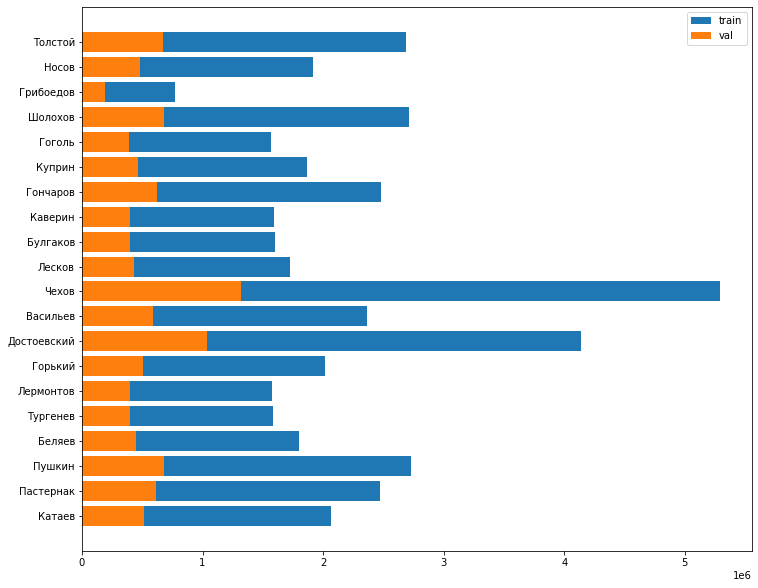

In [ ]:
plot_bar_statictics(x_train, x_val, class_list)

In [ ]:
# Токенизация и построение частотного словаря по обучающим текстам
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', 
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(x_train)

items = list(tokenizer.word_index.items())

In [ ]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])
print("Размер словаря", len(items)) 

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('что', 6), ('с', 7), ('я', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('его', 13), ('к', 14), ('но', 15), ('это', 16), ('по', 17), ('за', 18), ('у', 19), ('она', 20), ('все', 21), ('из', 22), ('так', 23), ('же', 24), ('от', 25), ('ты', 26), ('было', 27), ('вы', 28), ('да', 29), ('мне', 30), ('о', 31), ('меня', 32), ('ее', 33), ('бы', 34), ('только', 35), ('был', 36), ('ему', 37), ('еще', 38), ('когда', 39), ('вот', 40), ('сказал', 41), ('мы', 42), ('они', 43), ('ни', 44), ('до', 45), ('уже', 46), ('их', 47), ('нет', 48), ('ну', 49), ('для', 50), ('него', 51), ('или', 52), ('если', 53), ('ли', 54), ('теперь', 55), ('под', 56), ('быть', 57), ('вас', 58), ('себя', 59), ('где', 60), ('была', 61), ('очень', 62), ('во', 63), ('даже', 64), ('есть', 65), ('вам', 66), ('ничего', 67), ('со', 68), ('чем', 69), ('были', 70), ('может', 71), ('тут', 72), ('кто', 73), ('чтобы', 74), ('себе', 75), ('потом', 76), ('всё', 77),

In [ ]:
# Преобразование обучающих и проверочных текстов в последовательность индексов согласно частотному словарю
seq_train = tokenizer.texts_to_sequences(x_train)
seq_val = tokenizer.texts_to_sequences(x_val)

print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", x_train[1][:101])
print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:               ﻿ Доктор Живаго    И ДЫШАТ ПОЧВА И СУДЬБА            Спустя два года после завершения романа "Доктор 
Он же в виде последовательности индексов:  [337, 5912, 2, 1, 12723, 2, 1263, 1927, 127, 359, 108, 1, 2790, 337, 5912, 1519, 13050, 660, 8, 392]


In [ ]:
# Формирование обучающей и тестовой выборок
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP) 
x_val, y_val = vectorize_sequence(seq_val, WIN_SIZE, WIN_HOP)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(27560, 2000) (27560, 20)
(6815, 2000) (6815, 20)


## Добавление тестовых данных

In [ ]:
# Добавление проверочной выборки
from google.colab import files
uploaded = files.upload()

Saving Новый текстовый документ.txt to Новый текстовый документ.txt


In [ ]:
# Загрузка данных
x_test = []

with open('/content/Новый текстовый документ.txt', 'r') as f:
      text = f.read()
      
text = text.replace('\n', ' ')
x_test.append(text)

In [ ]:
# Вывод фрагмента текста и подсчет символов
print(x_test[0][200:], end='\n')
print(len(x_test[0]))

и нужны и кто определяет, что именно такие навыки являются приемлемыми для данной профессии.  	На́вык — способность деятельности, сформированная путем повторения и доведенная до автоматизма (такое определение дает википедия).  	Умение производить какую-либо деятельность и понимать, то что ты делаешь,наверное, и можно назвать навыком. Необходимые навыки для работы программистом довольно часто меняются и могут различаться даже казалось бы в идентичных ситуациях, кроме тех навыков, которые свойственны характеру человека и его подхода к работе. Причина почему необходимые навыки столь непостоянны довольно проста. Сфере информационных технологий, не так уж и много лет и она развивается с ошеломительной скоростью. Я бы хотел вкратце напомнить основные события в истории ИТ. Так как, мне кажется, без понимания истории той или иной сферы будет довольно сложно разбираться в основных аспектах работы в ней. История дает понимания того как все началось и как мы пришли к тому, где мы сейчас.  Термин 

In [ ]:
# Токенизация и построение частотного словаря по проверочным данных
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', 
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(x_test)

items = list(tokenizer.word_index.items())

In [ ]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])
print("Размер словаря", len(items)) 

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('на', 4), ('с', 5), ('что', 6), ('ит', 7), ('к', 8), ('это', 9), ('не', 10), ('навыки', 11), ('для', 12), ('которые', 13), ('как', 14), ('развития', 15), ('системы', 16), ('технологии', 17), ('я', 18), ('автомобили', 19), ('систем', 20), ('также', 21), ('чтобы', 22), ('можно', 23), ('то', 24), ('так', 25), ('без', 26), ('или', 27), ('х', 28), ('от', 29), ('из', 30), ('skill', 31), ('а', 32), ('более', 33), ('какие', 34), ('работы', 35), ('довольно', 36), ('будет', 37), ('информационные', 38), ('еще', 39), ('информации', 40), ('т', 41), ('д', 42), ('гг', 43), ('например', 44), ('быть', 45), ('беспилотных', 46), ('беспилотные', 47), ('проблема', 48), ('такие', 49), ('либо', 50), ('могут', 51), ('его', 52), ('у', 53), ('этап', 54), ('были', 55), ('людей', 56), ('но', 57), ('по', 58), ('может', 59), ('году', 60), ('мне', 61), ('кажется', 62), ('они', 63), ('именно', 64), ('профессии', 65), ('до', 66), ('технологий', 67), ('лет', 68), ('понима

In [ ]:
# Преобразование проверочной выборки в последовательность индексов согласно частотному словарю
seq_test = tokenizer.texts_to_sequences(x_test)

print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", x_test[0][:101])
print("Он же в виде последовательности индексов: ", seq_test[0][:20])

Фрагмент обучающего текста:
В виде оригинального текста:               В своем эссе я попытаюсь разобраться в теме того, какие навыки необходимы для того, чтобы стать прогр
Он же в виде последовательности индексов:  [3, 294, 295, 18, 296, 297, 3, 298, 88, 34, 11, 89, 12, 88, 22, 151, 152, 299, 13, 61]


In [ ]:
# Формирование проверочной выборки 
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP) 

print(x_test.shape, y_test.shape)

(1, 2000) (1, 1)


## Обучение модели

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 2000, 50)          1000000   
                                                                 
 spatial_dropout1d_14 (Spati  (None, 2000, 50)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_28 (Bat  (None, 2000, 50)         200       
 chNormalization)                                                
                                                                 
 bidirectional_12 (Bidirecti  (None, 2000, 20)         4880      
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 2000, 20)         2480      
 onal)                                               

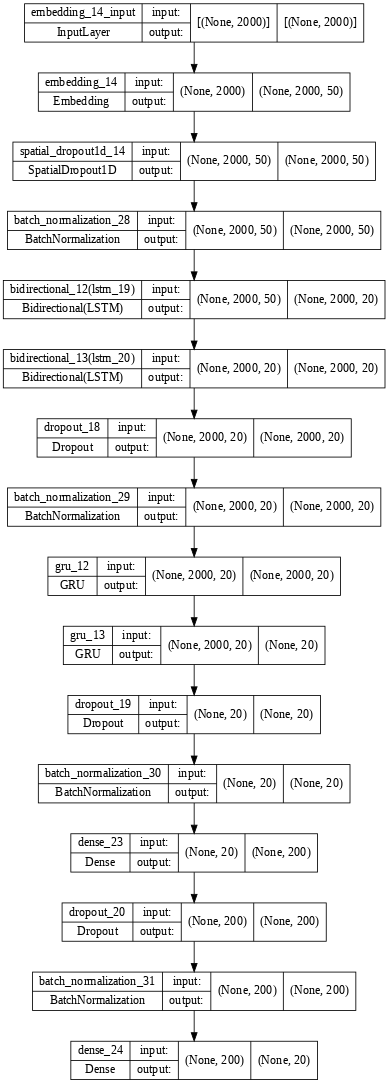

Epoch 1/15
216/216 [==============================] - 94s 394ms/step - loss: 3.2304 - accuracy: 0.0779 - val_loss: 2.9016 - val_accuracy: 0.1250
Epoch 2/15
216/216 [==============================] - 83s 385ms/step - loss: 2.8661 - accuracy: 0.1402 - val_loss: 2.5351 - val_accuracy: 0.1984
Epoch 3/15
216/216 [==============================] - 83s 383ms/step - loss: 2.4855 - accuracy: 0.2138 - val_loss: 2.4204 - val_accuracy: 0.2494
Epoch 4/15
216/216 [==============================] - 83s 387ms/step - loss: 2.0158 - accuracy: 0.3400 - val_loss: 2.1107 - val_accuracy: 0.3712
Epoch 5/15
216/216 [==============================] - 83s 384ms/step - loss: 1.3039 - accuracy: 0.5549 - val_loss: 2.0729 - val_accuracy: 0.4003
Epoch 6/15
216/216 [==============================] - 83s 386ms/step - loss: 0.6040 - accuracy: 0.7978 - val_loss: 1.3362 - val_accuracy: 0.6084
Epoch 7/15
216/216 [==============================] - 83s 386ms/step - loss: 0.2779 - accuracy: 0.9126 - val_loss: 1.1036 - val_ac

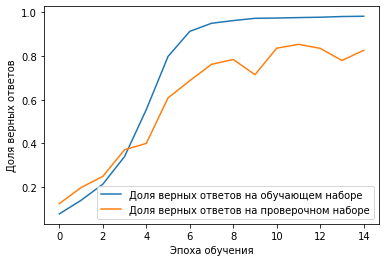

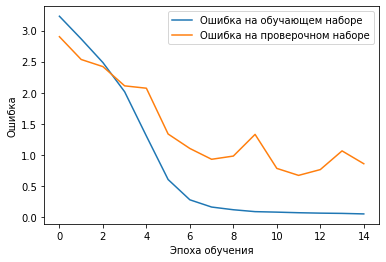

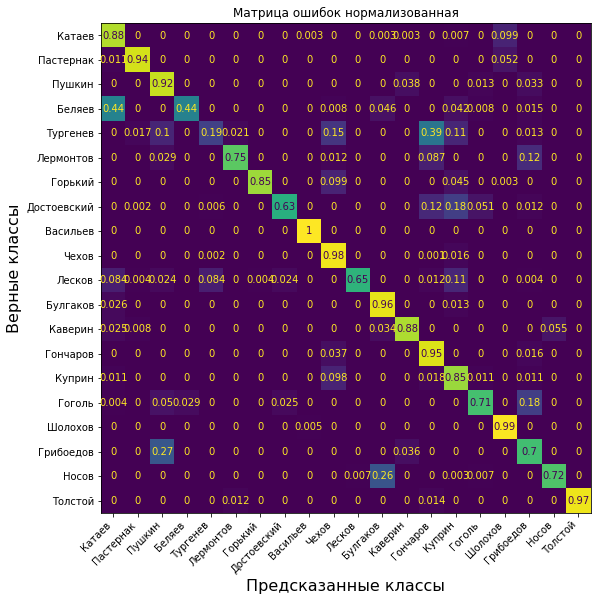

----------------------------------------------------------------------------------------------------
Класс: Катаев                88% сеть отнесла к классу Катаев               - ВЕРНО :-)
Класс: Пастернак             94% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Пушкин                92% сеть отнесла к классу Пушкин               - ВЕРНО :-)
Класс: Беляев                44% сеть отнесла к классу Катаев               - НЕВЕРНО :-(
Класс: Тургенев              39% сеть отнесла к классу Гончаров             - НЕВЕРНО :-(
Класс: Лермонтов             75% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Горький               85% сеть отнесла к классу Горький              - ВЕРНО :-)
Класс: Достоевский           63% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Васильев             100% сеть отнесла к классу Васильев             - ВЕРНО :-)
Класс: Чехов                 98% сеть отнесла к классу Чехов                - ВЕРНО :-)
Класс: Лесков  

In [ ]:
model_1 = Sequential()

model_1.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_1.add(SpatialDropout1D(0.3))
model_1.add(BatchNormalization())

model_1.add(Bidirectional(LSTM(10, return_sequences=True)))
model_1.add(Bidirectional(LSTM(10, return_sequences=True)))
model_1.add(Dropout(0.3))
model_1.add(BatchNormalization())

model_1.add(GRU(20, return_sequences=True, reset_after=True))
model_1.add(GRU(20, reset_after=True))
model_1.add(Dropout(0.3))
model_1.add(BatchNormalization())

model_1.add(Dense(200, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(BatchNormalization())
model_1.add(Dense(20, activation='softmax'))

model_embedding = build_model_embedding(model_1, class_list, x_train, y_train, x_val, y_val, EPOCHS)

In [ ]:
# Подключение к гугл диску и сохранение модели
from google.colab import drive 
drive.mount('/content/drive')  

model_1.save('drive/MyDrive/model/model_writers_rnn_80%.h5')

Mounted at /content/drive


## Проверка результатов

---

Похоже, что мои эссе были оценены не должным образом, так как мои 
тексты как-никак похожи на тексты Куприна!!!

---

In [ ]:
# Предсказание модели на проверочных данных
x_pred = model_1.predict(seq_test)

In [ ]:
# Вывод результата 
print(f'Полный вывод: \n {x_pred} \n\n')
print(f'Номер класса определенного нейронной сетью: {np.argmax(x_pred)} \n')
print(f'Наиболее похожим по стилю является: {class_list[np.argmax(x_pred)]}')

Полный вывод: 
 [[7.72998537e-05 5.89189585e-04 1.82885981e-06 5.36852394e-06
  6.80151582e-02 1.46159687e-06 6.71172165e-05 1.00562405e-02
  1.51266186e-05 9.85538494e-03 9.49069625e-04 2.09462651e-05
  2.30151963e-05 1.65960670e-01 7.40765631e-01 1.84801675e-03
  4.44435136e-06 1.70980359e-03 2.59356671e-06 3.16434234e-05]] 


Номер класса определенного нейронной сетью: 14 

Наиболее похожим по стилю является: Куприн
